# Survival Analysis :  Quick Implementation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from lifelines.plotting import plot_lifetimes      # Lifeline package for the Survival Analysis
%pylab inline
figsize(12,6)

Populating the interactive namespace from numpy and matplotlib


### Example with a fictitious data

<AxesSubplot:xlabel='timeline'>

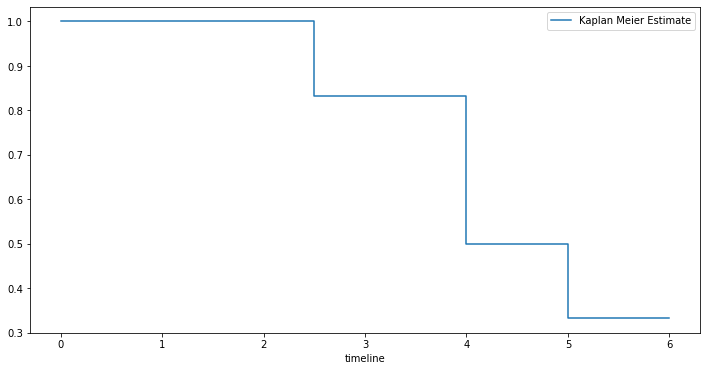

In [4]:
from lifelines import KaplanMeierFitter

## Example Data 
durations = [5,6,6,2.5,4,4]
event_observed = [1, 0, 0, 1, 1, 1]

## create an kmf object
kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
kmf.plot(ci_show=False) ## ci_show is meant for Confidence interval, since our data set is too tiny, thus i am not showing it.

## Real World Example 

### We will be using Telco Customer Churn data from Kaggle
https://www.kaggle.com/blastchar/telco-customer-churn/

In [5]:
##  create a dataframe
df =  pd.read_csv("./Data/latestdata.csv")

FileNotFoundError: [Errno 2] No such file or directory: './Data/latestdata.csv'

In [6]:
## Have a first look at the data
df.head() 

NameError: name 'df' is not defined

In [7]:
## Data Types and Missing Values in Columns
df.info()  

NameError: name 'df' is not defined

In [8]:
filtered = df[['date_confirmation','date_death_or_discharge','outcome','sex']].dropna()
filtered

,date_confirmation,date_death_or_discharge,outcome,sex
1,21.02.2020,22.02.2020,death,male
2,14.02.2020,17.02.2020,discharge,female
113,14.02.2020,20.02.2020,discharge,male
224,14.02.2020,02.03.2020,discharge,female
335,14.02.2020,29.02.2020,discharge,female
...,...,...,...,...
658603,31.01.2020,19.02.2020,recovered,female
658864,03.03.2020,26.02.2020,death,female
661086,01.03.2020,01.03.2020,death,female
670224,18.03.2020,19.03.2020,death,female


In [9]:
filtered["outcome"].value_counts()

died                        803
discharge                   150
discharged                   63
recovered                    53
death                        39
dead                          3
Discharged                    2
released from quarantine      2
Died                          1
Dead                          1
Deceased                      1
Death                         1
Name: outcome, dtype: int64

In [10]:
filtered['outcome']=filtered['outcome'].apply(lambda x: 1 if x == 'died' or x == 'death' or  x == 'dead' or x == 'Deceased' or x == 'Died' or x == 'Death' or x == 'Dead'else 0 )

In [11]:
filtered["outcome"].value_counts()

1    849
0    270
Name: outcome, dtype: int64

In [12]:
d,m,y = filtered.loc[1,['date_confirmation']][0].split('.')

In [13]:
from datetime import datetime

In [14]:
int(d)

21

In [15]:
length = len(filtered)
filtered.index = list(range(length))

In [16]:
filtered

,date_confirmation,date_death_or_discharge,outcome,sex
0,21.02.2020,22.02.2020,1,male
1,14.02.2020,17.02.2020,0,female
2,14.02.2020,20.02.2020,0,male
3,14.02.2020,02.03.2020,0,female
4,14.02.2020,29.02.2020,0,female
...,...,...,...,...
1114,31.01.2020,19.02.2020,0,female
1115,03.03.2020,26.02.2020,1,female
1116,01.03.2020,01.03.2020,1,female
1117,18.03.2020,19.03.2020,1,female


In [22]:
from datetime import datetime

days = []
for idx in range(length):
  conf = filtered.loc[idx,['date_confirmation']][0]
  if '-' in conf:
    a,b,c = conf.split(" - ")[0].split('.')
  else:
    a,b,c = conf.split('.')
  dead = filtered.loc[idx,['date_death_or_discharge']][0]
  if '-' in dead:
    x,y,z = dead.split(" - ")[0].split('.')
  else:
    x,y,z = dead.split('.')

  if int(y) > 12:
    t = x
    x=y
    y=t
  if int(b) > 12:
    t = a
    a=b
    b=t

  death = datetime(int(z),int(y),int(x),0,0,0)
  confirm = datetime(int(c),int(b),int(a),0,0,0)
  days.append((death-confirm).days)


In [23]:
filtered["days"] = days

In [24]:
filtered2 = filtered[filtered["days"]<0]
filtered2

,date_confirmation,date_death_or_discharge,outcome,sex,days
29,04.03.2020,03.03.2020,1,female,-1
33,24.01.2020,17.01.2020,0,male,-7
52,05.02.2020,30.01.2020,0,female,-6
72,06.03.2020,02.03.2020,1,male,-4
74,01.03.2020,26.02.2020,1,male,-4
...,...,...,...,...,...
1111,02.03.2020,01.03.2020,1,female,-1
1112,01.03.2020,29.02.2020,1,male,-1
1113,03.03.2020,26.02.2020,1,male,-6
1115,03.03.2020,26.02.2020,1,female,-6


In [25]:
for idx in range(length):
  d = int(filtered.loc[idx,['days']][0])
  if d < 0:
    conf = filtered.loc[idx,['date_confirmation']][0]
    if '-' in conf:
      a,b,c = conf.split(" - ")[0].split('.')
    else:
      a,b,c = conf.split('.')
    dead = filtered.loc[idx,['date_death_or_discharge']][0]
    if '-' in dead:
      x,y,z = dead.split(" - ")[0].split('.')
    else:
      x,y,z = dead.split('.')

    try:
      death = datetime(int(z),int(x),int(y),0,0,0)
      confirm = datetime(int(c),int(a),int(b),0,0,0)
      filtered.loc[idx,['days']] = -(death-confirm).days
    except:
      filtered.loc[idx,['days']] = None
  else:
    pass


In [26]:
filtered = filtered.dropna()

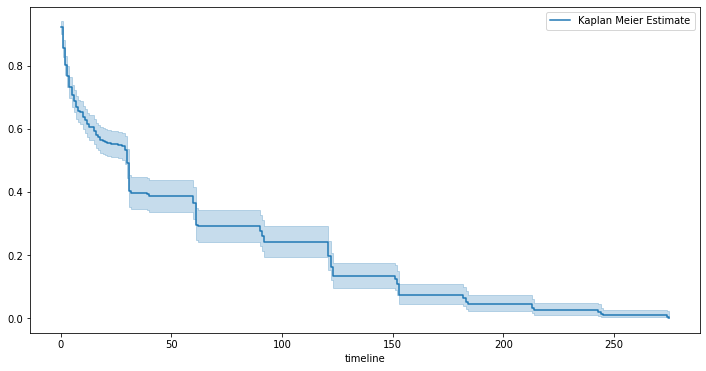

In [27]:
## Lets create an overall KaplanMeier curve, without breaking it into groups of covariates.

## Import the library
from lifelines import KaplanMeierFitter


durations = filtered['days'] ## Time to event data of censored and event data
event_observed = filtered['outcome']  ## It has the churned (1) and censored is (0)

## create a kmf object as km
km = KaplanMeierFitter() ## instantiate the class to create an object

## Fit the data into the model
km.fit(durations, event_observed,label='Kaplan Meier Estimate')

## Create an estimate
km.plot()

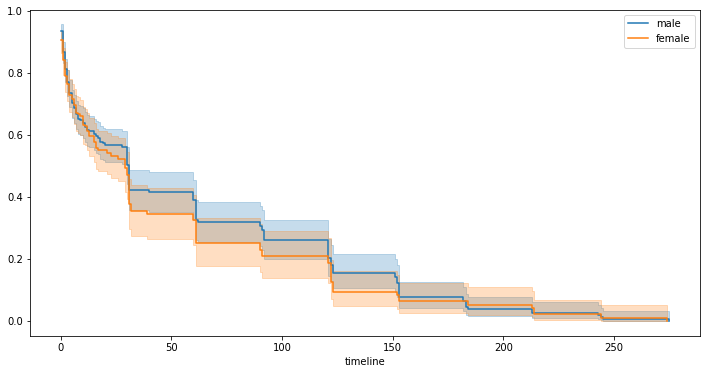

In [28]:
kmf = KaplanMeierFitter() 


T = filtered['days']     ## time to event
E = filtered['outcome']      ## event occurred or censored


groups = filtered['sex']             ## Create the cohorts from the 'Contract' column
ix1 = (groups == 'male')   ## Cohort 1
ix2 = (groups == 'female')         ## Cohort 2


kmf.fit(T[ix1], E[ix1], label='male')    ## fit the cohort 1 data
ax = kmf.plot()


kmf.fit(T[ix2], E[ix2], label='female')         ## fit the cohort 2 data
ax1 = kmf.plot(ax=ax)


## Cox Proportional Hazard Model (Survival Regression)

In [29]:
from lifelines import CoxPHFitter 

In [32]:
## My objective here is to introduce you to the implementation of the model.Thus taking subset of the columns to train the model.
## Only using the subset of the columns present in the original data
df_r= filtered.loc[:,['outcome','sex','days']]
df_r.head() ## have a look at the data 

,outcome,sex,days
0,1,male,1.0
1,0,female,3.0
2,0,male,6.0
3,0,female,17.0
4,0,female,15.0


In [33]:
## Create dummy variables
df_dummy = pd.get_dummies(df_r, drop_first=True)
df_dummy.head()

,outcome,days,sex_male
0,1,1.0,1
1,0,3.0,0
2,0,6.0,1
3,0,17.0,0
4,0,15.0,0


In [34]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object
cph.fit(df_dummy, 'days', event_col='outcome')   ## Fit the data to train the model
cph.print_summary()    ## HAve a look at the significance of the features

<lifelines.CoxPHFitter: fitted with 677 total observations, 266 right-censored observations>
             duration col = 'days'
                event col = 'outcome'
      baseline estimation = breslow
   number of observations = 677
number of events observed = 411
   partial log-likelihood = -2233.60
         time fit was run = 2021-01-15 02:58:44 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex_male   -0.08       0.92       0.10            -0.28             0.12                 0.76                 1.12

              z    p   -log2(p)
covariate                      
sex_male  -0.80 0.42       1.24
---
Concordance = 0.51
Partial AIC = 4469.20
log-likelihood ratio test = 0.63 on 1 df
-log2(p) of ll-ratio test = 1.23

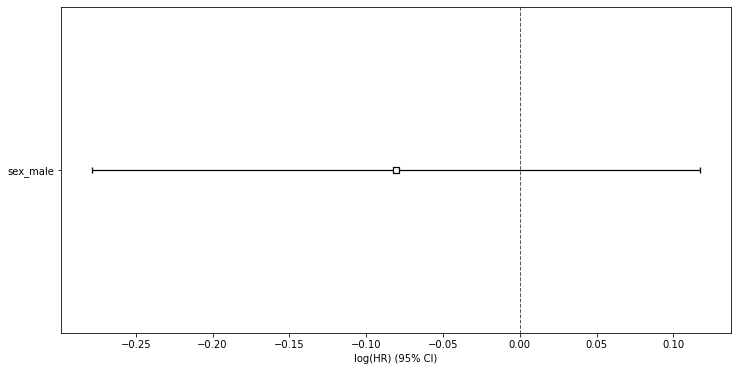

In [35]:
cph.plot()

In [40]:
tr_rows = df_dummy.iloc[15:17, 2:]
tr_rows

,sex_male
15,1
16,0


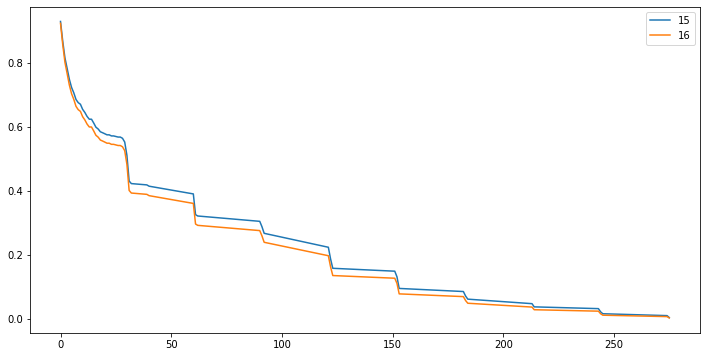

In [41]:
cph.predict_survival_function(tr_rows).plot()